<a href="https://colab.research.google.com/github/Capriale15/Artifitial-Inteligence-/blob/main/Data%20preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Setup and Installation
# @markdown Run this cell first to install and import necessary libraries
!pip install imbalanced-learn --quiet
!pip install albumentations --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import sklearn modules
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    PowerTransformer, OneHotEncoder, OrdinalEncoder, LabelEncoder,
    PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
)
from sklearn.feature_selection import (
    SelectKBest, chi2, f_classif, mutual_info_classif, f_regression,
    SelectFromModel, RFE
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import other libraries
from skimage import exposure
import cv2
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

print("All libraries installed and imported successfully!")

All libraries installed and imported successfully!


In [4]:
# @title Create Sample Datasets for Practice
# @markdown Run this cell to create sample datasets with various data issues

# Create a classification dataset with issues
X_clf, y_clf = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=42
)

df_clf = pd.DataFrame(X_clf, columns=[f'feature_{i}' for i in range(10)])
df_clf['target'] = y_clf

# Add categorical features
df_clf['category'] = np.random.choice(['A', 'B', 'C', 'D'], size=1000)
df_clf['ordinal_feature'] = np.random.choice(['Low', 'Medium', 'High'], size=1000)

# Add missing values (MCAR)
np.random.seed(42)
mask_mcar = np.random.random(df_clf.shape) < 0.1
df_clf = df_clf.mask(mask_mcar)

# Add missing values (MAR)
mar_mask = df_clf['feature_0'] > 0.5
df_clf.loc[mar_mask, 'feature_1'] = np.nan

# Add outliers
outlier_mask = np.random.random(1000) < 0.05
df_clf.loc[outlier_mask, 'feature_2'] = df_clf.loc[outlier_mask, 'feature_2'] * 10

# Create a regression dataset
X_reg, y_reg = make_regression(
    n_samples=800,
    n_features=8,
    n_informative=5,
    noise=0.1,
    random_state=42
)

df_reg = pd.DataFrame(X_reg, columns=[f'reg_feature_{i}' for i in range(8)])
df_reg['target'] = y_reg

# Add datetime feature
df_reg['date'] = pd.date_range('2020-01-01', periods=800, freq='D')

# Add missing values
mask_reg = np.random.random(df_reg.shape) < 0.08
df_reg = df_reg.mask(mask_reg)

print("Classification dataset shape:", df_clf.shape)
print("Regression dataset shape:", df_reg.shape)
print("\nClassification dataset info:")
print(df_clf.info())
print("\nMissing values in classification dataset:")
print(df_clf.isnull().sum())

Classification dataset shape: (1000, 13)
Regression dataset shape: (800, 10)

Classification dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   feature_0        904 non-null    float64
 1   feature_1        642 non-null    float64
 2   feature_2        906 non-null    float64
 3   feature_3        899 non-null    float64
 4   feature_4        901 non-null    float64
 5   feature_5        909 non-null    float64
 6   feature_6        897 non-null    float64
 7   feature_7        892 non-null    float64
 8   feature_8        891 non-null    float64
 9   feature_9        892 non-null    float64
 10  target           901 non-null    float64
 11  category         906 non-null    object 
 12  ordinal_feature  898 non-null    object 
dtypes: float64(11), object(2)
memory usage: 101.7+ KB
None

Missing values in classification dat

🔍 EXPLORATORY DATA ANALYSIS: Classification Dataset
Dimensions: (1000, 13)

Data types:
float64    11
object      2
Name: count, dtype: int64

Missing values:
                 Missing Values  Percentage (%)
feature_0                    96             9.6
feature_1                   358            35.8
feature_2                    94             9.4
feature_3                   101            10.1
feature_4                    99             9.9
feature_5                    91             9.1
feature_6                   103            10.3
feature_7                   108            10.8
feature_8                   109            10.9
feature_9                   108            10.8
target                       99             9.9
category                     94             9.4
ordinal_feature             102            10.2

Descriptive statistics:
        feature_0   feature_1   feature_2   feature_3   feature_4   feature_5  \
count  904.000000  642.000000  906.000000  899.000000  901.0000

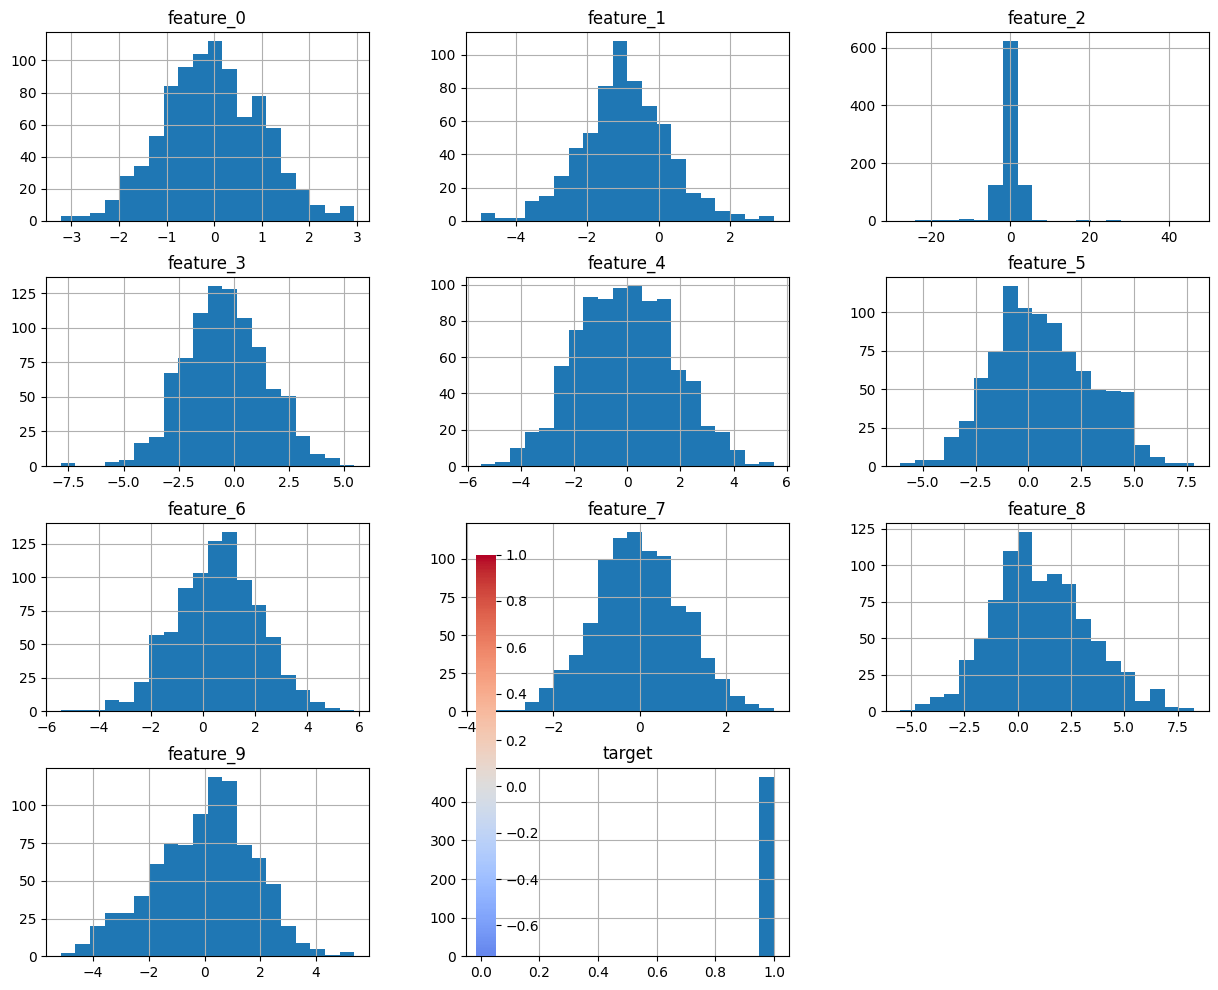


📊 Outlier Detection (IQR method):
feature_0: 5 outliers detected
feature_1: 18 outliers detected
feature_2: 39 outliers detected
feature_3: 6 outliers detected
feature_4: 3 outliers detected
feature_5: 3 outliers detected
feature_6: 5 outliers detected
feature_7: 5 outliers detected
feature_8: 6 outliers detected
feature_9: 5 outliers detected
🔍 EXPLORATORY DATA ANALYSIS: Regression Dataset
Dimensions: (800, 10)

Data types:
float64           9
datetime64[ns]    1
Name: count, dtype: int64

Missing values:
               Missing Values  Percentage (%)
reg_feature_0              78           9.750
reg_feature_1              78           9.750
reg_feature_2              60           7.500
reg_feature_3              68           8.500
reg_feature_4              52           6.500
reg_feature_5              51           6.375
reg_feature_6              67           8.375
reg_feature_7              88          11.000
target                     62           7.750
date                       

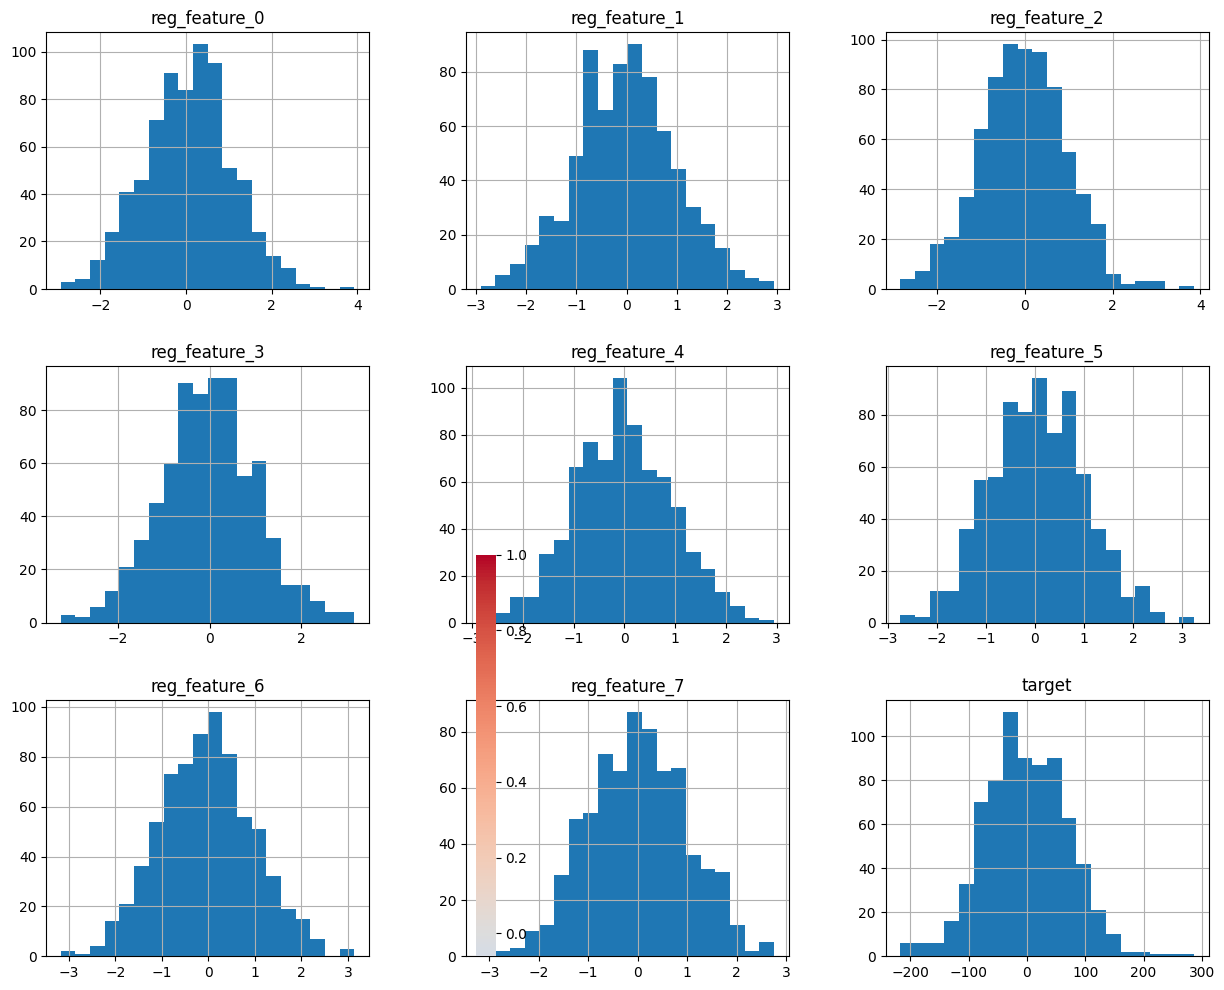


📊 Outlier Detection (IQR method):
reg_feature_0: 6 outliers detected
reg_feature_1: 4 outliers detected
reg_feature_2: 11 outliers detected
reg_feature_3: 12 outliers detected
reg_feature_4: 4 outliers detected
reg_feature_5: 5 outliers detected
reg_feature_6: 6 outliers detected
reg_feature_7: 5 outliers detected
target: 10 outliers detected


In [5]:
# @title Exploratory Data Analysis (EDA)
# @markdown Run this cell to perform exploratory data analysis

def perform_eda(df, dataset_name):
    print(f"🔍 EXPLORATORY DATA ANALYSIS: {dataset_name}")
    print("=" * 50)

    # Basic information
    print(f"Dimensions: {df.shape}")
    print(f"\nData types:\n{df.dtypes.value_counts()}")

    # Missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_percentage
    })
    print(f"\nMissing values:\n{missing_df[missing_df['Missing Values'] > 0]}")

    # Descriptive statistics for numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(f"\nDescriptive statistics:\n{df[numerical_cols].describe()}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'EDA for {dataset_name}', fontsize=16)

    # Histograms for numerical columns
    if len(numerical_cols) > 0:
        df[numerical_cols].hist(ax=axes[0, 0], bins=20)
        axes[0, 0].set_title('Distribution of Numerical Features')
        axes[0, 0].tick_params(axis='x', rotation=45)

    # Missing values heatmap
    sns.heatmap(df.isnull(), cbar=False, ax=axes[0, 1])
    axes[0, 1].set_title('Missing Values Heatmap')

    # Correlation heatmap (if enough numerical columns)
    if len(numerical_cols) > 1:
        corr_matrix = df[numerical_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
        axes[1, 0].set_title('Correlation Matrix')

    # Count plot for categorical columns (if any)
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        for i, col in enumerate(categorical_cols[:1]):  # Show first categorical column only
            if i == 0:
                value_counts = df[col].value_counts()
                axes[1, 1].bar(value_counts.index.astype(str), value_counts.values)
                axes[1, 1].set_title(f'Distribution of {col}')
                axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Check for outliers using IQR
    if len(numerical_cols) > 0:
        print("\n📊 Outlier Detection (IQR method):")
        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            if len(outliers) > 0:
                print(f"{col}: {len(outliers)} outliers detected")

# Perform EDA on both datasets
perform_eda(df_clf, "Classification Dataset")
perform_eda(df_reg, "Regression Dataset")

In [6]:
# @title Handling Missing Values
# @markdown Run this cell to see different methods for handling missing values

def handle_missing_values(df, target_column=None):
    print("🔄 HANDLING MISSING VALUES")
    print("=" * 40)

    # Create a copy of the dataframe
    df_processed = df.copy()

    # Identify numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    # Remove target column if specified
    if target_column and target_column in numerical_cols:
        numerical_cols = numerical_cols.drop(target_column)

    # 1. Simple Imputation
    print("\n1. Simple Imputation Methods:")

    # For numerical columns
    if len(numerical_cols) > 0:
        # Mean imputation
        mean_imputer = SimpleImputer(strategy='mean')
        df_mean = df_processed.copy()
        df_mean[numerical_cols] = mean_imputer.fit_transform(df_mean[numerical_cols])
        print("   Mean imputation completed")

        # Median imputation (more robust to outliers)
        median_imputer = SimpleImputer(strategy='median')
        df_median = df_processed.copy()
        df_median[numerical_cols] = median_imputer.fit_transform(df_median[numerical_cols])
        print("   Median imputation completed")

    # For categorical columns
    if len(categorical_cols) > 0:
        mode_imputer = SimpleImputer(strategy='most_frequent')
        df_mode = df_processed.copy()
        df_mode[categorical_cols] = mode_imputer.fit_transform(df_mode[categorical_cols])
        print("   Mode imputation completed")

    # 2. Advanced Imputation Methods
    print("\n2. Advanced Imputation Methods:")

    # KNN Imputation
    if len(numerical_cols) > 0:
        knn_imputer = KNNImputer(n_neighbors=5)
        df_knn = df_processed.copy()
        df_knn[numerical_cols] = knn_imputer.fit_transform(df_knn[numerical_cols])
        print("   KNN imputation completed")

    # MICE Imputation (Iterative Imputer)
    if len(numerical_cols) > 0:
        mice_imputer = IterativeImputer(random_state=42, max_iter=10)
        df_mice = df_processed.copy()
        df_mice[numerical_cols] = mice_imputer.fit_transform(df_mice[numerical_cols])
        print("   MICE imputation completed")

    # 3. Indicator Variables
    print("\n3. Indicator Variable Method:")
    df_indicator = df_processed.copy()
    for col in numerical_cols:
        if df_indicator[col].isnull().sum() > 0:
            df_indicator[f'{col}_missing'] = df_indicator[col].isnull().astype(int)

    # Then impute the missing values
    simple_imputer = SimpleImputer(strategy='median')
    df_indicator[numerical_cols] = simple_imputer.fit_transform(df_indicator[numerical_cols])
    print("   Indicator variables added and missing values imputed")

    return {
        'mean_imputation': df_mean if len(numerical_cols) > 0 else df_processed,
        'median_imputation': df_median if len(numerical_cols) > 0 else df_processed,
        'mode_imputation': df_mode if len(categorical_cols) > 0 else df_processed,
        'knn_imputation': df_knn if len(numerical_cols) > 0 else df_processed,
        'mice_imputation': df_mice if len(numerical_cols) > 0 else df_processed,
        'indicator_method': df_indicator
    }

# Handle missing values for classification dataset
clf_missing_results = handle_missing_values(df_clf, 'target')
print("\nMissing values handling completed for classification dataset")

# Handle missing values for regression dataset
reg_missing_results = handle_missing_values(df_reg, 'target')
print("Missing values handling completed for regression dataset")

🔄 HANDLING MISSING VALUES

1. Simple Imputation Methods:
   Mean imputation completed
   Median imputation completed
   Mode imputation completed

2. Advanced Imputation Methods:
   KNN imputation completed
   MICE imputation completed

3. Indicator Variable Method:
   Indicator variables added and missing values imputed

Missing values handling completed for classification dataset
🔄 HANDLING MISSING VALUES

1. Simple Imputation Methods:
   Mean imputation completed
   Median imputation completed

2. Advanced Imputation Methods:
   KNN imputation completed
   MICE imputation completed

3. Indicator Variable Method:
   Indicator variables added and missing values imputed
Missing values handling completed for regression dataset


📊 HANDLING OUTLIERS

Analyzing feature_0:
   IQR outliers: 17
   Z-score outliers: 2
   Applied winsorization to feature_0

Analyzing feature_1:
   IQR outliers: 216
   Z-score outliers: 17
   Applied winsorization to feature_1

Analyzing feature_2:
   IQR outliers: 45
   Z-score outliers: 23
   Applied winsorization to feature_2

Analyzing feature_3:
   IQR outliers: 18
   Z-score outliers: 4
   Applied winsorization to feature_3

Analyzing feature_4:
   IQR outliers: 4
   Z-score outliers: 3
   Applied winsorization to feature_4

Analyzing feature_5:
   IQR outliers: 5
   Z-score outliers: 3
   Applied winsorization to feature_5

Analyzing feature_6:
   IQR outliers: 21
   Z-score outliers: 3
   Applied winsorization to feature_6

Analyzing feature_7:
   IQR outliers: 15
   Z-score outliers: 4
   Applied winsorization to feature_7

Analyzing feature_8:
   IQR outliers: 26
   Z-score outliers: 5
   Applied winsorization to feature_8

Analyzing feature_9:
   IQR outliers: 12
   Z-score

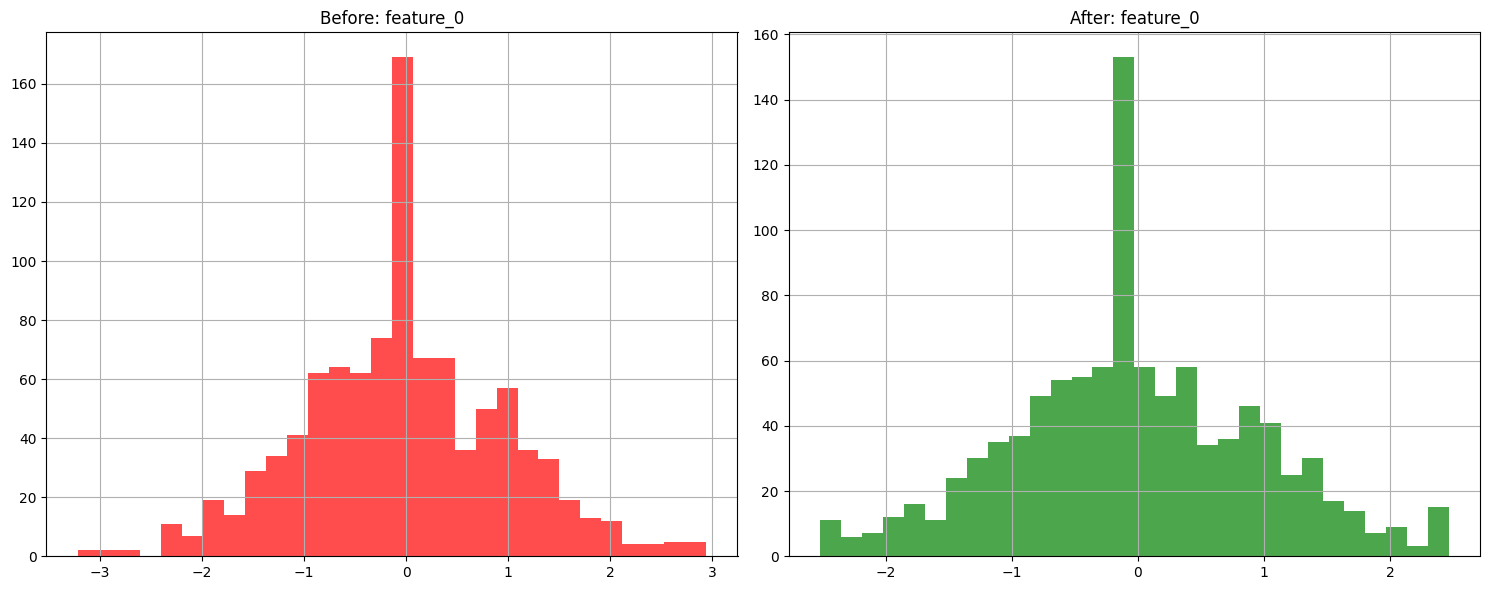

📊 HANDLING OUTLIERS

Analyzing reg_feature_0:
   IQR outliers: 14
   Z-score outliers: 4
   Applied winsorization to reg_feature_0

Analyzing reg_feature_1:
   IQR outliers: 16
   Z-score outliers: 2
   Applied winsorization to reg_feature_1

Analyzing reg_feature_2:
   IQR outliers: 16
   Z-score outliers: 5
   Applied winsorization to reg_feature_2

Analyzing reg_feature_3:
   IQR outliers: 21
   Z-score outliers: 5
   Applied winsorization to reg_feature_3

Analyzing reg_feature_4:
   IQR outliers: 9
   Z-score outliers: 1
   Applied winsorization to reg_feature_4

Analyzing reg_feature_5:
   IQR outliers: 6
   Z-score outliers: 3
   Applied winsorization to reg_feature_5

Analyzing reg_feature_6:
   IQR outliers: 13
   Z-score outliers: 4
   Applied winsorization to reg_feature_6

Analyzing reg_feature_7:
   IQR outliers: 13
   Z-score outliers: 5
   Applied winsorization to reg_feature_7


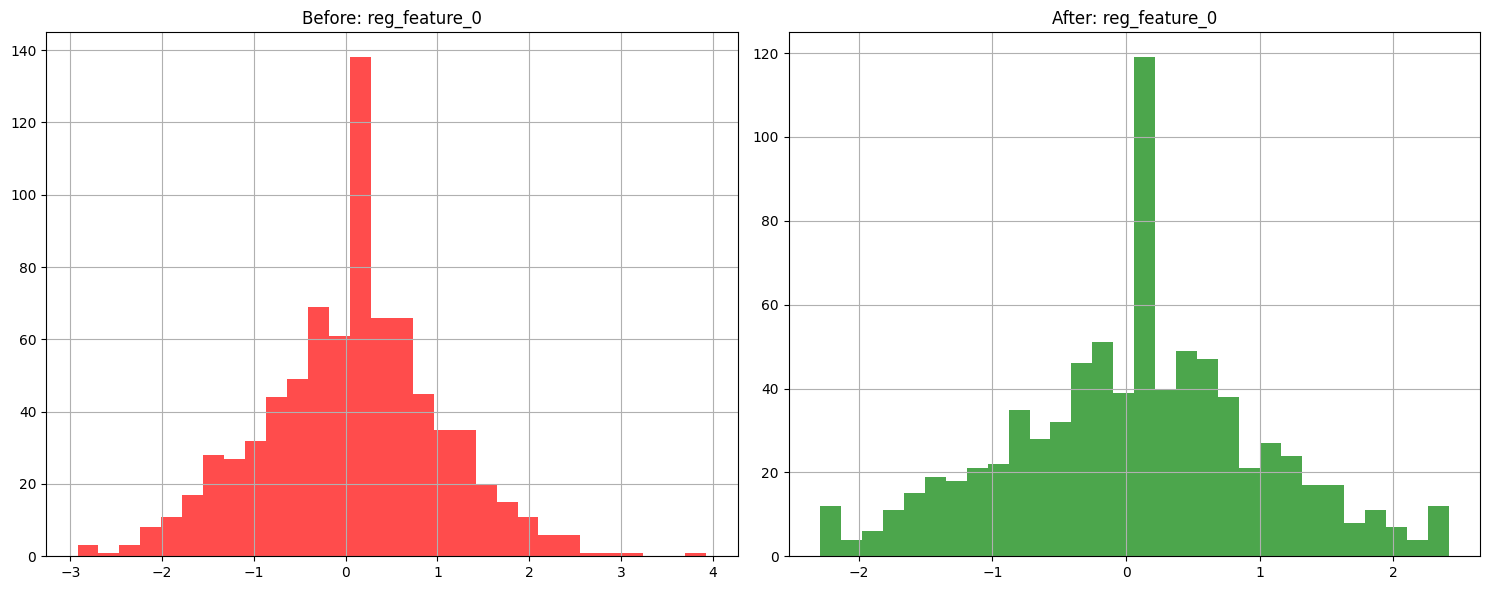

Outlier handling completed for both datasets


In [7]:
# @title Handling Outliers
# @markdown Run this cell to detect and handle outliers

def handle_outliers(df, numerical_cols=None):
    print("📊 HANDLING OUTLIERS")
    print("=" * 40)

    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=[np.number]).columns

    df_processed = df.copy()
    outlier_report = {}

    for col in numerical_cols:
        print(f"\nAnalyzing {col}:")

        # Skip if too many missing values
        if df_processed[col].isnull().sum() / len(df_processed) > 0.5:
            print(f"   Skipping {col} - too many missing values")
            continue

        # 1. IQR Method
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound_iqr = Q1 - 1.5 * IQR
        upper_bound_iqr = Q3 + 1.5 * IQR

        iqr_outliers = df_processed[(df_processed[col] < lower_bound_iqr) | (df_processed[col] > upper_bound_iqr)]

        # 2. Z-score Method
        z_scores = np.abs(stats.zscore(df_processed[col].dropna()))
        z_outliers = df_processed[z_scores > 3] if len(z_scores) > 0 else pd.DataFrame()

        outlier_report[col] = {
            'iqr_outliers': len(iqr_outliers),
            'zscore_outliers': len(z_outliers),
            'lower_bound_iqr': lower_bound_iqr,
            'upper_bound_iqr': upper_bound_iqr
        }

        print(f"   IQR outliers: {len(iqr_outliers)}")
        print(f"   Z-score outliers: {len(z_outliers)}")

        # Apply winsorization if outliers detected
        if len(iqr_outliers) > 0:
            # Winsorization (capping outliers)
            df_processed[col] = np.clip(df_processed[col], lower_bound_iqr, upper_bound_iqr)
            print(f"   Applied winsorization to {col}")

    # Visualization
    if len(numerical_cols) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Before handling
        df[numerical_cols[0]].hist(ax=axes[0], bins=30, alpha=0.7, color='red')
        axes[0].set_title(f'Before: {numerical_cols[0]}')

        # After handling
        df_processed[numerical_cols[0]].hist(ax=axes[1], bins=30, alpha=0.7, color='green')
        axes[1].set_title(f'After: {numerical_cols[0]}')

        plt.tight_layout()
        plt.show()

    return df_processed, outlier_report

# Handle outliers for classification dataset
clf_numerical_cols = df_clf.select_dtypes(include=[np.number]).columns.drop('target', errors='ignore')
df_clf_no_outliers, clf_outlier_report = handle_outliers(clf_missing_results['median_imputation'], clf_numerical_cols)

# Handle outliers for regression dataset
reg_numerical_cols = df_reg.select_dtypes(include=[np.number]).columns.drop('target', errors='ignore')
df_reg_no_outliers, reg_outlier_report = handle_outliers(reg_missing_results['median_imputation'], reg_numerical_cols)

print("Outlier handling completed for both datasets")

📏 FEATURE SCALING AND TRANSFORMATION
✓ Standard scaling completed
✓ Min-Max scaling completed
✓ Robust scaling completed
✓ Power transformation (Yeo-Johnson) completed
✓ Log transformation completed (where applicable)


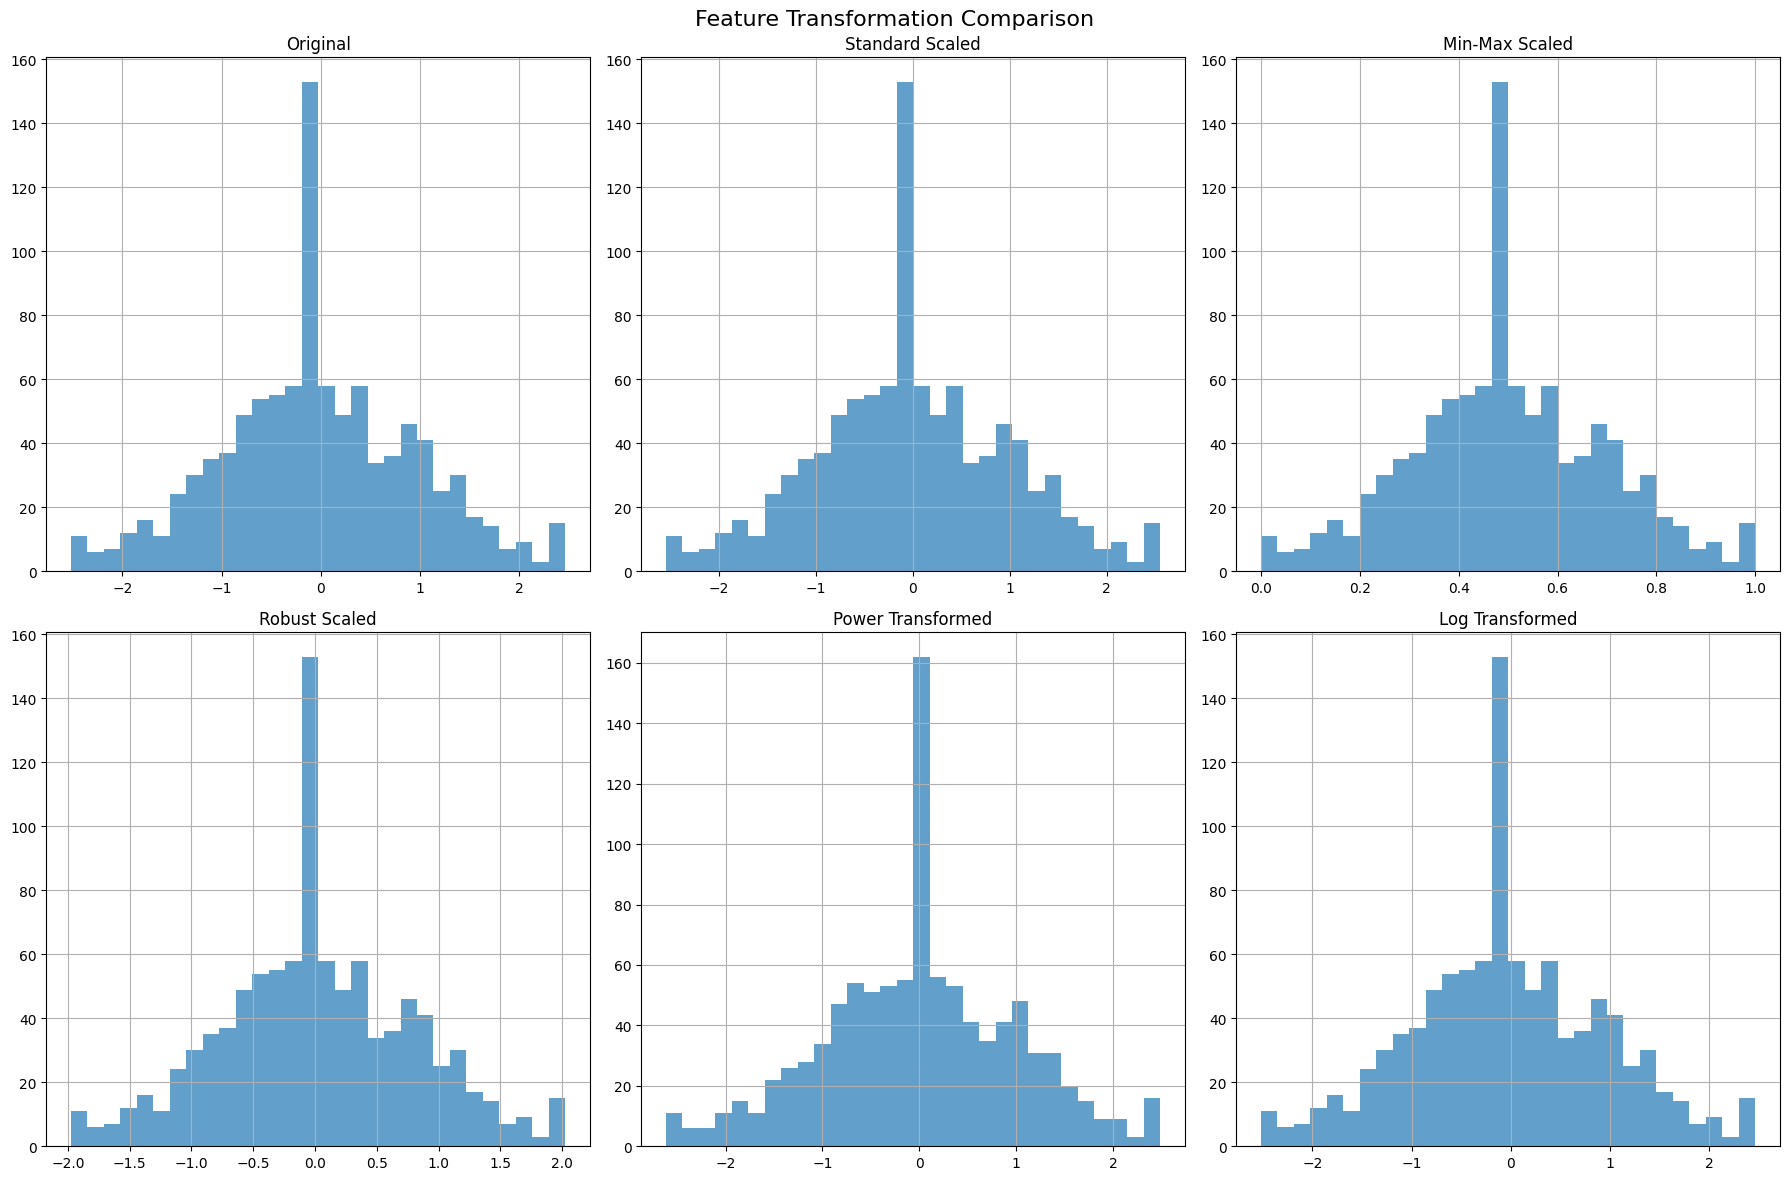

📏 FEATURE SCALING AND TRANSFORMATION
✓ Standard scaling completed
✓ Min-Max scaling completed
✓ Robust scaling completed
✓ Power transformation (Yeo-Johnson) completed
✓ Log transformation completed (where applicable)


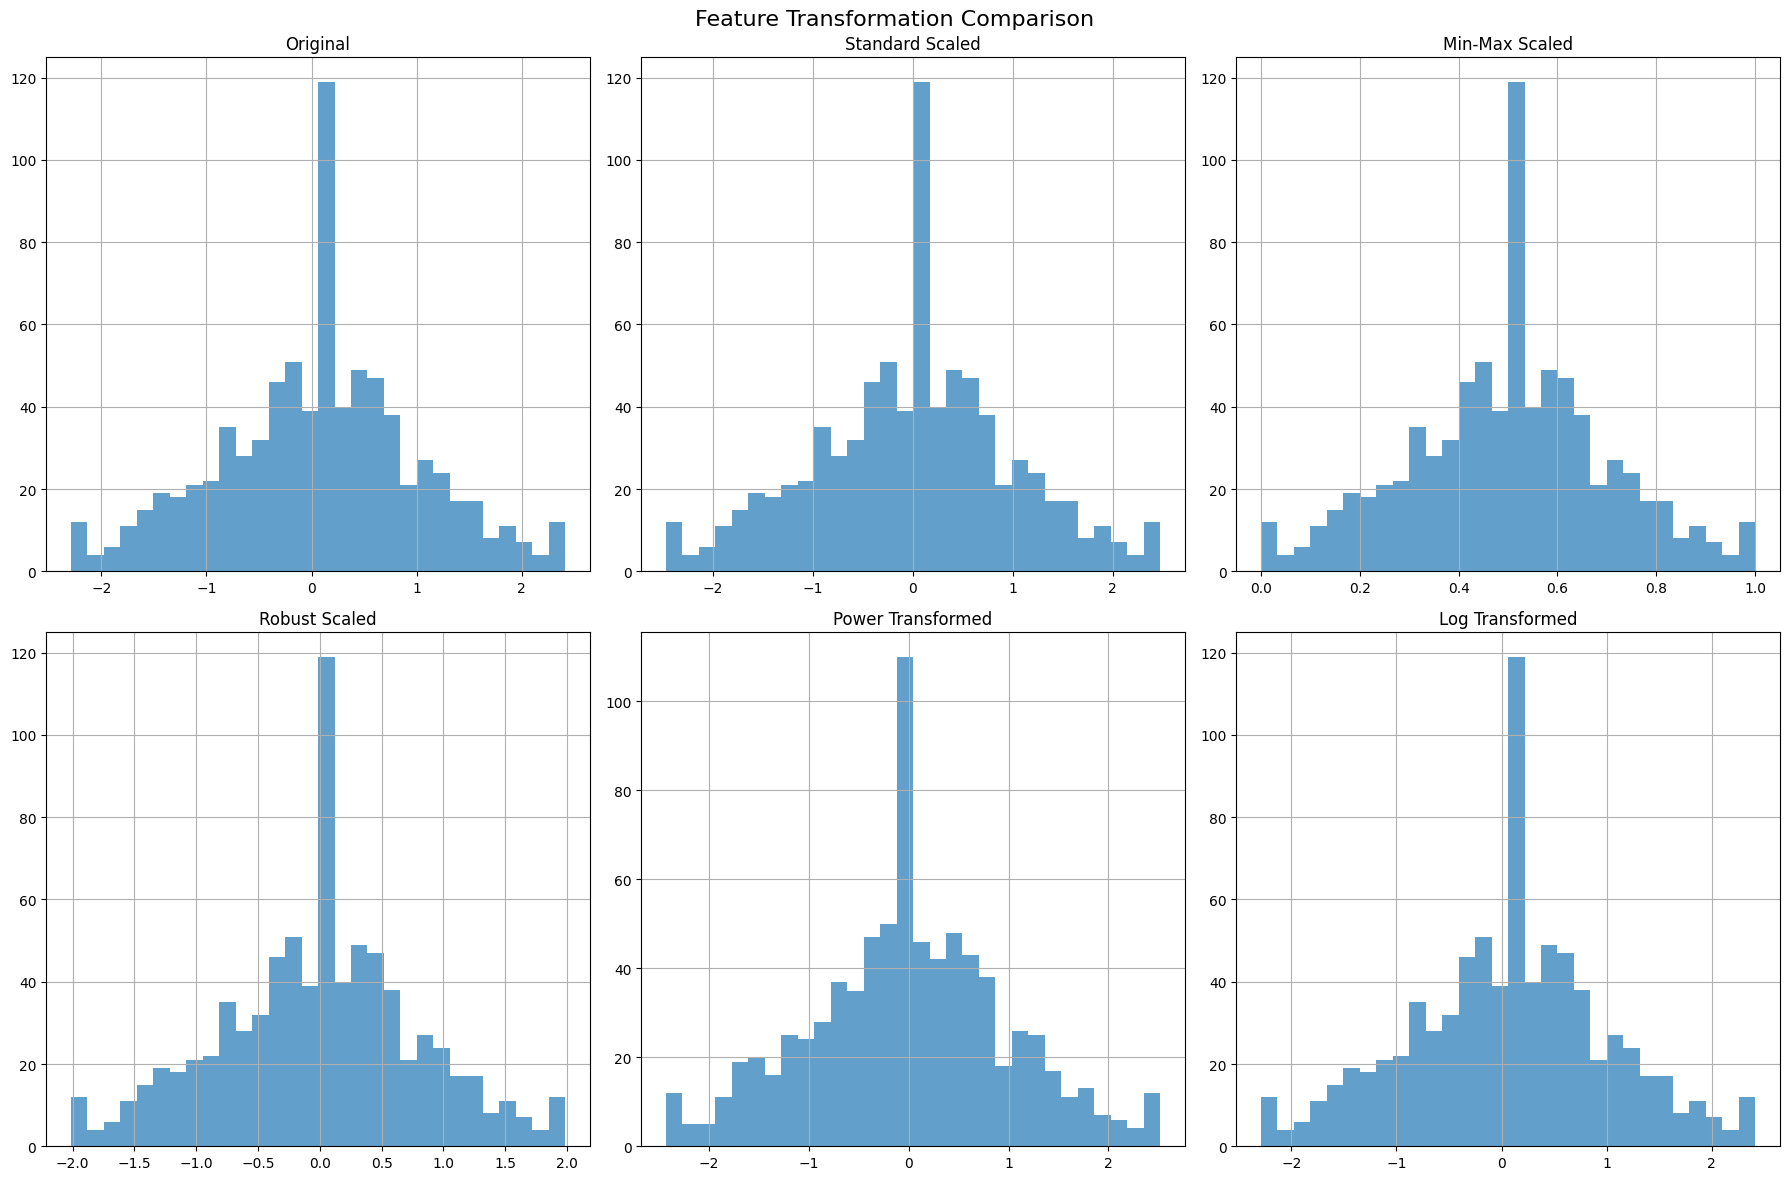

Feature scaling and transformation completed for both datasets


In [8]:
# @title Feature Scaling and Transformation
# @markdown Run this cell to apply feature scaling and transformations

def scale_and_transform_features(df, target_column=None):
    print("📏 FEATURE SCALING AND TRANSFORMATION")
    print("=" * 50)

    df_processed = df.copy()

    # Identify numerical columns (excluding target)
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    if target_column and target_column in numerical_cols:
        numerical_cols = numerical_cols.drop(target_column)

    if len(numerical_cols) == 0:
        print("No numerical features to scale/transform")
        return df_processed

    results = {}

    # 1. Standard Scaling (Z-score normalization)
    scaler_standard = StandardScaler()
    df_standard = df_processed.copy()
    df_standard[numerical_cols] = scaler_standard.fit_transform(df_standard[numerical_cols])
    results['standard_scaled'] = df_standard
    print("✓ Standard scaling completed")

    # 2. Min-Max Scaling
    scaler_minmax = MinMaxScaler()
    df_minmax = df_processed.copy()
    df_minmax[numerical_cols] = scaler_minmax.fit_transform(df_minmax[numerical_cols])
    results['minmax_scaled'] = df_minmax
    print("✓ Min-Max scaling completed")

    # 3. Robust Scaling (for data with outliers)
    scaler_robust = RobustScaler()
    df_robust = df_processed.copy()
    df_robust[numerical_cols] = scaler_robust.fit_transform(df_robust[numerical_cols])
    results['robust_scaled'] = df_robust
    print("✓ Robust scaling completed")

    # 4. Power Transformations
    # Yeo-Johnson (handles positive and negative values)
    pt = PowerTransformer(method='yeo-johnson')
    df_power = df_processed.copy()
    df_power[numerical_cols] = pt.fit_transform(df_power[numerical_cols])
    results['power_transformed'] = df_power
    print("✓ Power transformation (Yeo-Johnson) completed")

    # 5. Log Transformation (for highly skewed data)
    df_log = df_processed.copy()
    for col in numerical_cols:
        # Only apply log transform to positive values
        if df_log[col].min() > 0:
            df_log[col] = np.log1p(df_log[col])
    results['log_transformed'] = df_log
    print("✓ Log transformation completed (where applicable)")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Feature Transformation Comparison', fontsize=16)

    # Original
    df_processed[numerical_cols[0]].hist(ax=axes[0, 0], bins=30, alpha=0.7)
    axes[0, 0].set_title('Original')

    # Standard Scaled
    df_standard[numerical_cols[0]].hist(ax=axes[0, 1], bins=30, alpha=0.7)
    axes[0, 1].set_title('Standard Scaled')

    # Min-Max Scaled
    df_minmax[numerical_cols[0]].hist(ax=axes[0, 2], bins=30, alpha=0.7)
    axes[0, 2].set_title('Min-Max Scaled')

    # Robust Scaled
    df_robust[numerical_cols[0]].hist(ax=axes[1, 0], bins=30, alpha=0.7)
    axes[1, 0].set_title('Robust Scaled')

    # Power Transformed
    df_power[numerical_cols[0]].hist(ax=axes[1, 1], bins=30, alpha=0.7)
    axes[1, 1].set_title('Power Transformed')

    # Log Transformed
    if numerical_cols[0] in df_log.columns:
        df_log[numerical_cols[0]].hist(ax=axes[1, 2], bins=30, alpha=0.7)
        axes[1, 2].set_title('Log Transformed')

    plt.tight_layout()
    plt.show()

    return results

# Apply scaling and transformation to classification dataset
clf_scaling_results = scale_and_transform_features(df_clf_no_outliers, 'target')

# Apply scaling and transformation to regression dataset
reg_scaling_results = scale_and_transform_features(df_reg_no_outliers, 'target')

print("Feature scaling and transformation completed for both datasets")

In [9]:
# @title Categorical Variable Encoding
# @markdown Run this cell to encode categorical variables

def encode_categorical_variables(df, target_column=None):
    print("🔤 CATEGORICAL VARIABLE ENCODING")
    print("=" * 50)

    df_processed = df.copy()

    # Identify categorical columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    if len(categorical_cols) == 0:
        print("No categorical features to encode")
        return df_processed

    results = {}

    # 1. One-Hot Encoding
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    df_onehot = df_processed.copy()

    # Apply one-hot encoding
    onehot_encoded = onehot_encoder.fit_transform(df_onehot[categorical_cols])
    onehot_columns = onehot_encoder.get_feature_names_out(categorical_cols)

    # Create DataFrame with one-hot encoded features
    df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=onehot_columns, index=df_onehot.index)

    # Drop original categorical columns and concatenate with encoded ones
    df_onehot = df_onehot.drop(categorical_cols, axis=1)
    df_onehot = pd.concat([df_onehot, df_onehot_encoded], axis=1)

    results['onehot_encoded'] = df_onehot
    print("✓ One-hot encoding completed")

    # 2. Ordinal Encoding
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_ordinal = df_processed.copy()

    df_ordinal[categorical_cols] = ordinal_encoder.fit_transform(df_ordinal[categorical_cols])
    results['ordinal_encoded'] = df_ordinal
    print("✓ Ordinal encoding completed")

    # 3. Frequency Encoding
    df_frequency = df_processed.copy()

    for col in categorical_cols:
        frequency_map = df_frequency[col].value_counts().to_dict()
        df_frequency[f'{col}_freq'] = df_frequency[col].map(frequency_map)

    # Drop original categorical columns
    df_frequency = df_frequency.drop(categorical_cols, axis=1)
    results['frequency_encoded'] = df_frequency
    print("✓ Frequency encoding completed")

    # 4. Target Encoding (with cross-validation to avoid data leakage)
    if target_column and target_column in df_processed.columns:
        df_target = df_processed.copy()
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for col in categorical_cols:
            df_target[f'{col}_target_encoded'] = np.nan

            for train_idx, val_idx in kf.split(df_target):
                X_train, X_val = df_target.iloc[train_idx], df_target.iloc[val_idx]

                # Calculate mean target per category in training fold
                mean_encoding = X_train.groupby(col)[target_column].mean()

                # Apply to validation fold
                df_target.iloc[val_idx, df_target.columns.get_loc(f'{col}_target_encoded')] = (
                    X_val[col].map(mean_encoding)
                )

        # Drop original categorical columns
        df_target = df_target.drop(categorical_cols, axis=1)
        results['target_encoded'] = df_target
        print("✓ Target encoding completed")

    return results

# Encode categorical variables for classification dataset
clf_encoding_results = encode_categorical_variables(clf_scaling_results['standard_scaled'], 'target')

# Encode categorical variables for regression dataset
reg_encoding_results = encode_categorical_variables(reg_scaling_results['standard_scaled'], 'target')

print("Categorical variable encoding completed for both datasets")

🔤 CATEGORICAL VARIABLE ENCODING
✓ One-hot encoding completed
✓ Ordinal encoding completed
✓ Frequency encoding completed
✓ Target encoding completed
🔤 CATEGORICAL VARIABLE ENCODING
No categorical features to encode
Categorical variable encoding completed for both datasets


In [17]:
# --- imports necesarios ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def _as_series(df, col):
    """Devuelve una Serie 1D aun si hay nombres duplicados."""
    obj = df[col]
    if isinstance(obj, pd.DataFrame):
        # si hay nombres duplicados, toma la primera columna
        obj = obj.iloc[:, 0]
    return obj

def perform_feature_engineering(df, target_column=None):
    print("⚙️ FEATURE ENGINEERING")
    print("=" * 40)

    df_engineered = df.copy()

    # Identificar columnas numéricas ORIGINALES (antes de agregar features)
    original_numerical = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
    if target_column in original_numerical:
        original_numerical.remove(target_column)

    # 1) Polynomial Features (prefijadas para evitar duplicados)
    if len(original_numerical) >= 2:
        try:
            cols_for_poly = original_numerical[:min(3, len(original_numerical))]
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            poly_features = poly.fit_transform(df_engineered[cols_for_poly])
            poly_names = [f"poly__{n}" for n in poly.get_feature_names_out(cols_for_poly)]
            poly_df = pd.DataFrame(poly_features, columns=poly_names, index=df_engineered.index)
            df_engineered = pd.concat([df_engineered, poly_df], axis=1)
            print("✓ Polynomial features created")
        except Exception as e:
            print(f"✗ Polynomial features failed: {e}")

    # 2) Interaction Feature (entre las 2 primeras columnas numéricas ORIGINALES)
    if len(original_numerical) >= 2:
        try:
            c1, c2 = original_numerical[0], original_numerical[1]
            s1 = _as_series(df_engineered, c1)
            s2 = _as_series(df_engineered, c2)
            df_engineered[f'interaction__{c1}__x__{c2}'] = s1.to_numpy() * s2.to_numpy()
            print("✓ Interaction features created")
        except Exception as e:
            print(f"✗ Interaction features failed: {e}")

    # 3) Binning/Discretization (solo sobre columnas ORIGINALES para evitar 2D)
    if len(original_numerical) > 0:
        try:
            for col in original_numerical[:2]:
                s = _as_series(df_engineered, col)
                df_engineered[f'{col}__equal_width_bin'] = pd.cut(s, bins=5, labels=False)
                df_engineered[f'{col}__equal_freq_bin'] = pd.qcut(s, q=5, labels=False, duplicates='drop')
            print("✓ Binning features created")
        except Exception as e:
            print(f"✗ Binning features failed: {e}")

    # 4) DateTime Features
    datetime_cols = df_engineered.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns
    if len(datetime_cols) > 0:
        try:
            for col in datetime_cols:
                s = _as_series(df_engineered, col)
                df_engineered[f'{col}__year']       = s.dt.year
                df_engineered[f'{col}__month']      = s.dt.month
                df_engineered[f'{col}__day']        = s.dt.day
                df_engineered[f'{col}__dow']        = s.dt.dayofweek
                df_engineered[f'{col}__is_weekend'] = s.dt.dayofweek.isin([5, 6]).astype(int)
            print("✓ DateTime features created")
        except Exception as e:
            print(f"✗ DateTime features failed: {e}")



    # 5) Statistical Features (sobre columnas numéricas actuales SIN target)
    try:
        current_num = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
        if target_column in current_num:
            current_num.remove(target_column)
        if len(current_num) > 0:
            df_engineered['mean_features'] = df_engineered[current_num].mean(axis=1)
            df_engineered['std_features']  = df_engineered[current_num].std(axis=1)
            print("✓ Statistical features created")
    except Exception as e:
        print(f"✗ Statistical features failed: {e}")

    print(f"Original shape: {df.shape}")
    print(f"Engineered shape: {df_engineered.shape}")
    return df_engineered

# --- Carga robusta de tus DataFrames (evita KeyError 'onehot_encoded') ---
def _resolve_df(obj):
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, dict):
        # prueba claves comunes
        for k in ('onehot_encoded', 'encoded', 'df', 'data'):
            if k in obj and isinstance(obj[k], pd.DataFrame):
                return obj[k]
    raise KeyError("No pude encontrar un DataFrame dentro del objeto proporcionado.")

# Uso:
df_clf_in = _resolve_df(clf_encoding_results)
df_reg_in = _resolve_df(reg_encoding_results)

df_clf_engineered = perform_feature_engineering(df_clf_in, target_column='target')
df_reg_engineered = perform_feature_engineering(df_reg_in,  target_column='target')

print("Feature engineering completed for both datasets")


⚙️ FEATURE ENGINEERING
✓ Polynomial features created
✓ Interaction features created
✓ Binning features created
✓ Statistical features created
Original shape: (1000, 20)
Engineered shape: (1000, 33)
⚙️ FEATURE ENGINEERING
✓ Polynomial features created
✓ Interaction features created
✓ Binning features created
✓ DateTime features created
✓ Statistical features created
Original shape: (800, 10)
Engineered shape: (800, 28)
Feature engineering completed for both datasets


🎯 FEATURE SELECTION
↳ Dropping 99 rows with NaN in target 'target'

1. Filter Methods:
✓ ANOVA F-test completed
✓ Mutual Information completed

2. Embedded Methods:
✓ Random Forest importance completed
✓ L1-Logistic (Lasso) completed

Selected top 15 features:
['feature_5', 'feature_9', 'feature_6', 'poly__feature_1 feature_2', 'feature_3', 'feature_4', 'feature_8', 'poly__feature_2', 'feature_2', 'mean_features', 'std_features', 'poly__feature_0 feature_2', 'feature_7', 'interaction__feature_0__x__feature_1', 'poly__feature_0 feature_1']


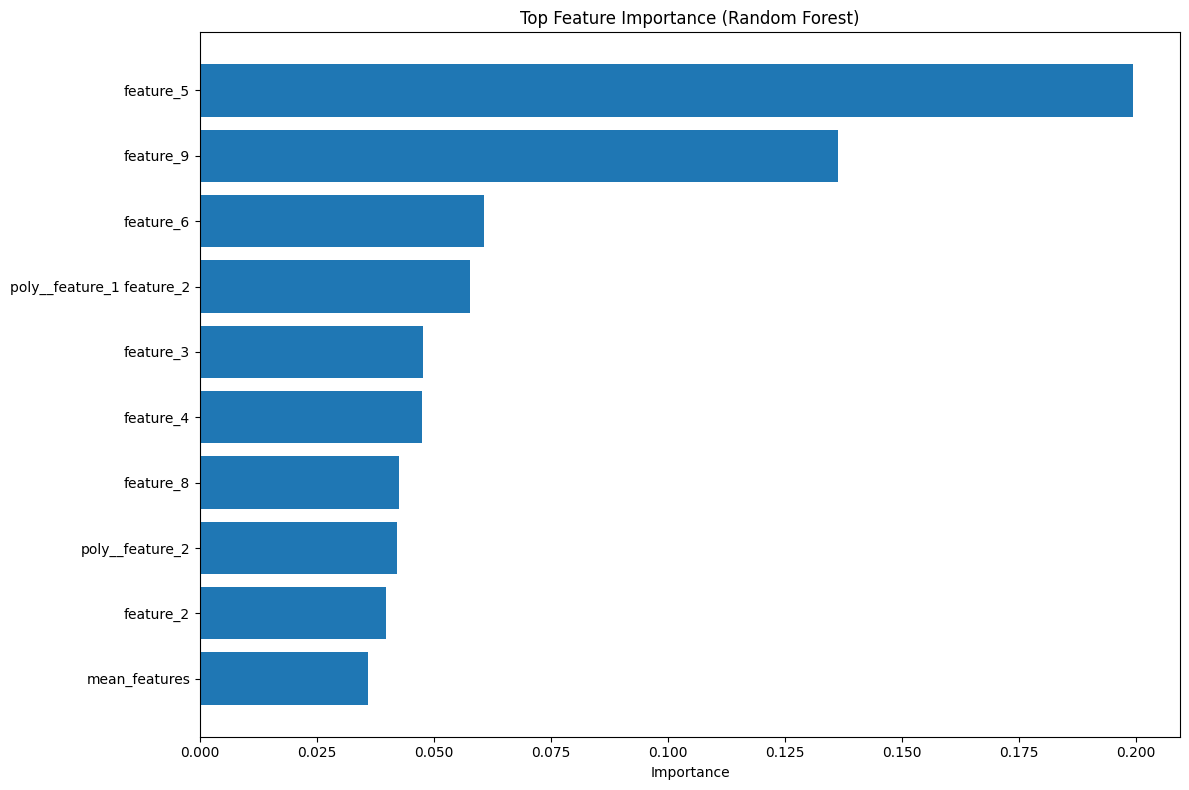


📌 Top features (clasificación):
['feature_5', 'feature_9', 'feature_6', 'poly__feature_1 feature_2', 'feature_3', 'feature_4', 'feature_8', 'poly__feature_2', 'feature_2', 'mean_features', 'std_features', 'poly__feature_0 feature_2', 'feature_7', 'interaction__feature_0__x__feature_1', 'poly__feature_0 feature_1']

🔝 RF Importances (Top 15):


,feature,importance
5,feature_5,0.199365
9,feature_9,0.136261
6,feature_6,0.060658
24,poly__feature_1 feature_2,0.057742
3,feature_3,0.047607
4,feature_4,0.047495
8,feature_8,0.042415
21,poly__feature_2,0.041996
2,feature_2,0.039779
30,mean_features,0.035926



📊 ANOVA F-test (Top 15):


,feature,anova_score
5,feature_5,346.709750
9,feature_9,264.730645
24,poly__feature_1 feature_2,65.492737
6,feature_6,60.809835
3,feature_3,33.517609
8,feature_8,11.774531
28,feature_1__equal_width_bin,4.143182
29,feature_1__equal_freq_bin,3.983499
20,poly__feature_1,2.600537
1,feature_1,2.600537



🧠 Mutual Information (Top 15):


,feature,mi_score
5,feature_5,0.159018
9,feature_9,0.135714
24,poly__feature_1 feature_2,0.037896
8,feature_8,0.024850
3,feature_3,0.022166
26,feature_0__equal_width_bin,0.022026
18,ordinal_feature_nan,0.021349
15,ordinal_feature_High,0.016638
1,feature_1,0.015011
4,feature_4,0.013490



💾 Archivos guardados en 'feature_reports/':
total 280K
-rw-r--r-- 1 root root 1.2K Sep  6 18:13 clf_anova_scores.csv
-rw-r--r-- 1 root root  997 Sep  6 18:13 clf_mi_scores.csv
-rw-r--r-- 1 root root 1.2K Sep  6 18:13 clf_rf_importance.csv
-rw-r--r-- 1 root root 266K Sep  6 18:13 clf_selected_dataset.csv
🎯 FEATURE SELECTION
↳ Dropping 62 rows with NaN in target 'target'

1. Filter Methods:
✓ F-test completed

2. Embedded Methods:
✓ Random Forest importance completed

Selected top 15 features:
['poly__reg_feature_2', 'reg_feature_2', 'reg_feature_4', 'reg_feature_5', 'poly__reg_feature_1 reg_feature_2', 'reg_feature_3', 'reg_feature_1', 'poly__reg_feature_1', 'reg_feature_6', 'reg_feature_7', 'mean_features', 'poly__reg_feature_0 reg_feature_2', 'date__month', 'std_features', 'poly__reg_feature_0 reg_feature_1']


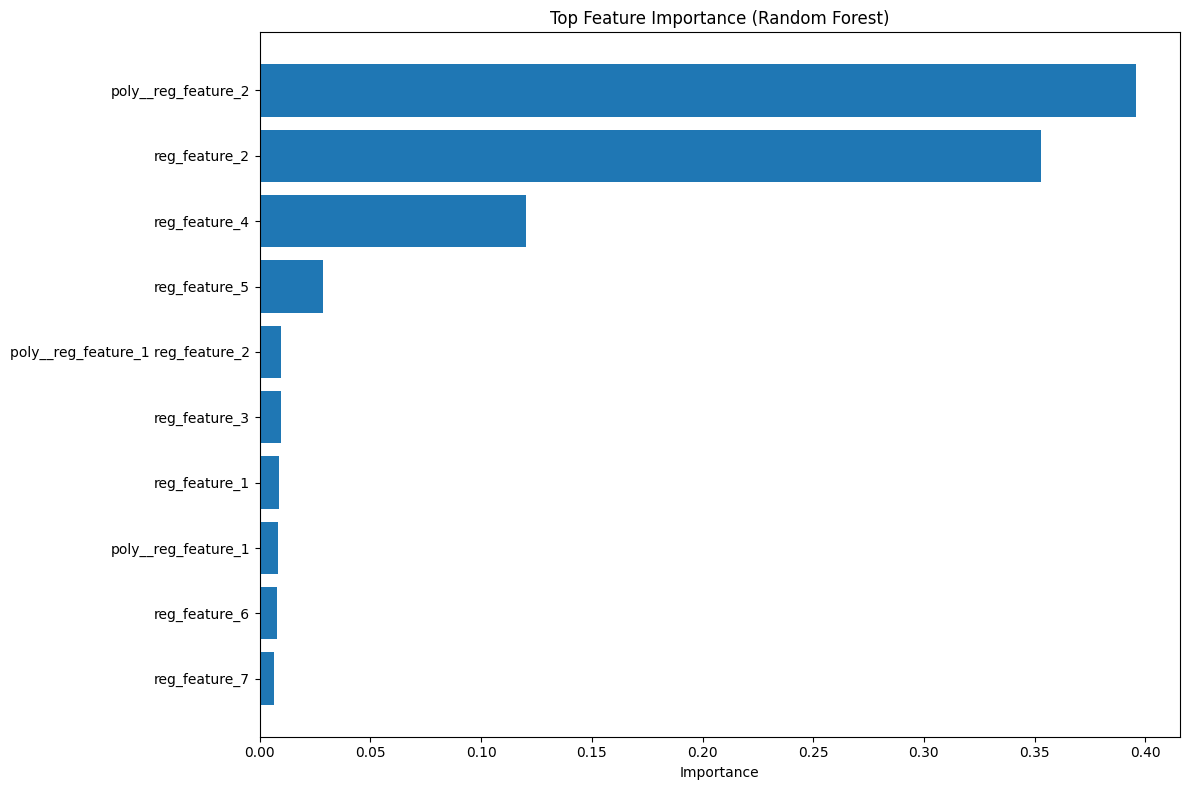


📌 Top features (regresión):
['poly__reg_feature_2', 'reg_feature_2', 'reg_feature_4', 'reg_feature_5', 'poly__reg_feature_1 reg_feature_2', 'reg_feature_3', 'reg_feature_1', 'poly__reg_feature_1', 'reg_feature_6', 'reg_feature_7', 'mean_features', 'poly__reg_feature_0 reg_feature_2', 'date__month', 'std_features', 'poly__reg_feature_0 reg_feature_1']

🔝 RF Importances (Top 15) [regresión]:


,feature,importance
10,poly__reg_feature_2,0.395875
2,reg_feature_2,0.352693
4,reg_feature_4,0.120382
5,reg_feature_5,0.028573
13,poly__reg_feature_1 reg_feature_2,0.009453
3,reg_feature_3,0.009393
1,reg_feature_1,0.008858
9,poly__reg_feature_1,0.008173
6,reg_feature_6,0.007883
7,reg_feature_7,0.006448



📊 F-test (Top 15) [regresión]:


,feature,f_score
2,reg_feature_2,1920.004143
10,poly__reg_feature_2,1920.004143
4,reg_feature_4,86.748070
5,reg_feature_5,22.631108
17,reg_feature_1__equal_width_bin,14.691272
18,reg_feature_1__equal_freq_bin,12.384876
9,poly__reg_feature_1,12.303063
1,reg_feature_1,12.303063
20,date__month,4.282087
19,date__year,2.427129



💾 Archivos guardados en 'feature_reports/':
total 504K
-rw-r--r-- 1 root root 1.2K Sep  6 18:13 clf_anova_scores.csv
-rw-r--r-- 1 root root  997 Sep  6 18:13 clf_mi_scores.csv
-rw-r--r-- 1 root root 1.2K Sep  6 18:13 clf_rf_importance.csv
-rw-r--r-- 1 root root 266K Sep  6 18:13 clf_selected_dataset.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:13 reg_f_scores.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:13 reg_rf_importance.csv
-rw-r--r-- 1 root root 215K Sep  6 18:13 reg_selected_dataset.csv


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

def perform_feature_selection(df, target_column, problem_type='classification'):
    print("🎯 FEATURE SELECTION")
    print("=" * 40)

    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in DataFrame")
        return df, {}

    # 0) Separar X/y
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 1) Asegurar solo numéricas en X
    X = X.select_dtypes(include=[np.number])

    if X.shape[1] == 0:
        print("No numerical features available for selection")
        return df, {}

    # 2) Limpiar y: quitar NaN y alinear X/y
    rows_before = len(df)
    valid_mask = y.notna()
    if valid_mask.sum() < rows_before:
        print(f"↳ Dropping {rows_before - valid_mask.sum()} rows with NaN in target '{target_column}'")
    X = X.loc[valid_mask].copy()
    y = y.loc[valid_mask].copy()

    # 3) Limpiar X: reemplazar inf y NaN -> imputación mediana
    X = X.replace([np.inf, -np.inf], np.nan)
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

    results = {}

    # 4) Preparar y según problema
    if problem_type == 'classification':
        # Convertir y a etiquetas 0..K-1 de forma robusta
        if y.dtype.kind in {'O', 'U', 'S'} or str(y.dtype).startswith('category'):
            y_encoded, uniques = pd.factorize(y)
            y = pd.Series(y_encoded, index=y.index)
            results['class_labels_'] = list(uniques)
        else:
            # Si es bool -> int
            if y.dtype == bool:
                y = y.astype(int)
            # Si es float con valores enteros, mantener
        n_classes = np.unique(y).size
        if n_classes < 2:
            print("⚠️ Only one class present in y after cleaning. Skipping classification-based selectors.")
            # En este caso devolvemos las primeras columnas por fallback
            top_features = list(X_imputed.columns[:min(10, X_imputed.shape[1])])
            df_selected = df.loc[X_imputed.index, top_features + [target_column]]
            return df_selected, results
    else:
        # regression: asegurar numérico
        try:
            y = pd.to_numeric(y)
        except Exception:
            raise ValueError("Target for regression could not be converted to numeric.")

    # 5) Métodos Filter
    print("\n1. Filter Methods:")
    try:
        if problem_type == 'classification':
            # ANOVA F-test
            selector_anova = SelectKBest(score_func=f_classif, k='all')
            selector_anova.fit(X_imputed, y)
            anova_scores = pd.DataFrame({'feature': X_imputed.columns,
                                         'anova_score': selector_anova.scores_}).sort_values('anova_score', ascending=False)
            results['anova_scores'] = anova_scores
            print("✓ ANOVA F-test completed")

            # Mutual Information
            selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
            selector_mi.fit(X_imputed, y)
            mi_scores = pd.DataFrame({'feature': X_imputed.columns,
                                      'mi_score': selector_mi.scores_}).sort_values('mi_score', ascending=False)
            results['mi_scores'] = mi_scores
            print("✓ Mutual Information completed")
        else:
            selector_f = SelectKBest(score_func=f_regression, k='all')
            selector_f.fit(X_imputed, y)
            f_scores = pd.DataFrame({'feature': X_imputed.columns,
                                     'f_score': selector_f.scores_}).sort_values('f_score', ascending=False)
            results['f_scores'] = f_scores
            print("✓ F-test completed")
    except Exception as e:
        print(f"✗ Filter methods failed: {e}")

    # 6) Métodos Embedded
    print("\n2. Embedded Methods:")
    try:
        if problem_type == 'classification':
            rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
            rf.fit(X_imputed, y)
            rf_importance = pd.DataFrame({'feature': X_imputed.columns,
                                          'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
            results['rf_importance'] = rf_importance
            print("✓ Random Forest importance completed")

            # L1 (Logistic Regression)
            # Notas: si muchas features >> filas o clases desbalanceadas, liblinear va bien.
            lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=2000)
            lasso.fit(X_imputed, y)
            # Si es multiclass, coef_.shape = (n_classes, n_features) -> usar norma L1 promedio
            coef = lasso.coef_
            if coef.ndim == 2 and coef.shape[0] > 1:
                coef_abs = np.mean(np.abs(coef), axis=0)
            else:
                coef_abs = np.abs(coef).ravel()
            lasso_importance = pd.DataFrame({'feature': X_imputed.columns,
                                             'coefficient_abs': coef_abs}).sort_values('coefficient_abs', ascending=False)
            results['lasso_importance'] = lasso_importance
            print("✓ L1-Logistic (Lasso) completed")
        else:
            rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
            rf.fit(X_imputed, y)
            rf_importance = pd.DataFrame({'feature': X_imputed.columns,
                                          'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
            results['rf_importance'] = rf_importance
            print("✓ Random Forest importance completed")
    except Exception as e:
        print(f"✗ Embedded methods failed: {e}")

    # 7) Seleccionar top N (por RF si existe; si no, usar fallback por varianza)
    if 'rf_importance' in results and not results['rf_importance'].empty:
        topN = min(15, len(results['rf_importance']))
        top_features = results['rf_importance'].head(topN)['feature'].tolist()
    else:
        # Fallback: top por varianza
        variances = X_imputed.var().sort_values(ascending=False)
        topN = min(15, len(variances))
        top_features = list(variances.head(topN).index)
        print("⚠️ Using variance-based fallback for top features.")

    df_selected = df.loc[X_imputed.index, top_features + [target_column]]

    print(f"\nSelected top {len(top_features)} features:")
    print(top_features)

    # 8) Visualización (si hay importancias RF)
    if 'rf_importance' in results and not results['rf_importance'].empty:
        plt.figure(figsize=(12, 8))
        top_10 = results['rf_importance'].head(min(10, len(results['rf_importance'])))
        plt.barh(top_10['feature'], top_10['importance'])
        plt.xlabel('Importance')
        plt.title('Top Feature Importance (Random Forest)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return df_selected, results


🎯 FEATURE SELECTION
↳ Dropping 99 rows with NaN in target 'target'

1. Filter Methods:
✓ ANOVA F-test completed
✓ Mutual Information completed

2. Embedded Methods:
✓ Random Forest importance completed
✓ L1-Logistic (Lasso) completed

Selected top 15 features:
['feature_5', 'feature_9', 'feature_6', 'poly__feature_1 feature_2', 'feature_3', 'feature_4', 'feature_8', 'poly__feature_2', 'feature_2', 'mean_features', 'std_features', 'poly__feature_0 feature_2', 'feature_7', 'interaction__feature_0__x__feature_1', 'poly__feature_0 feature_1']


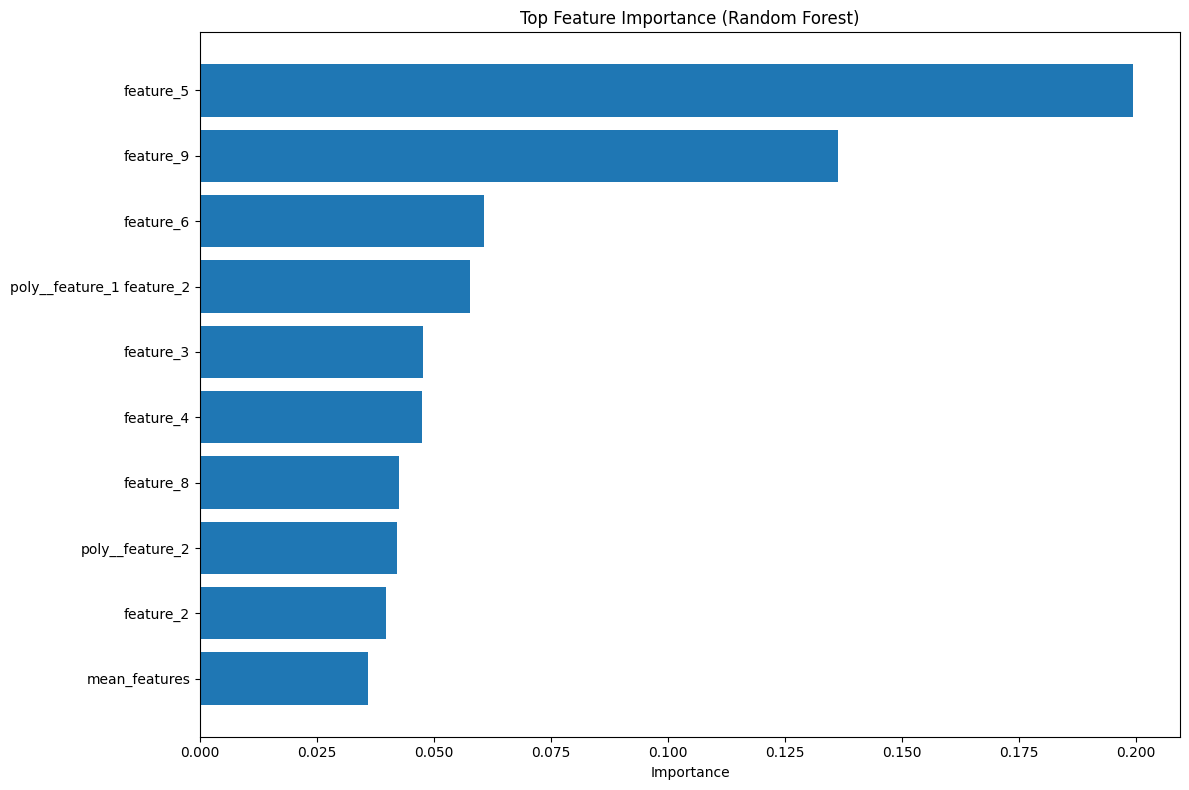


📌 Top features (clasificación):
['feature_5', 'feature_9', 'feature_6', 'poly__feature_1 feature_2', 'feature_3', 'feature_4', 'feature_8', 'poly__feature_2', 'feature_2', 'mean_features', 'std_features', 'poly__feature_0 feature_2', 'feature_7', 'interaction__feature_0__x__feature_1', 'poly__feature_0 feature_1']

🔝 RF Importances (Top 15):


,feature,importance
5,feature_5,0.199365
9,feature_9,0.136261
6,feature_6,0.060658
24,poly__feature_1 feature_2,0.057742
3,feature_3,0.047607
4,feature_4,0.047495
8,feature_8,0.042415
21,poly__feature_2,0.041996
2,feature_2,0.039779
30,mean_features,0.035926



📊 ANOVA F-test (Top 15):


,feature,anova_score
5,feature_5,346.709750
9,feature_9,264.730645
24,poly__feature_1 feature_2,65.492737
6,feature_6,60.809835
3,feature_3,33.517609
8,feature_8,11.774531
28,feature_1__equal_width_bin,4.143182
29,feature_1__equal_freq_bin,3.983499
20,poly__feature_1,2.600537
1,feature_1,2.600537



🧠 Mutual Information (Top 15):


,feature,mi_score
5,feature_5,0.160943
9,feature_9,0.139774
24,poly__feature_1 feature_2,0.035768
3,feature_3,0.033480
26,feature_0__equal_width_bin,0.021163
28,feature_1__equal_width_bin,0.020601
8,feature_8,0.018556
11,category_B,0.018039
6,feature_6,0.014852
4,feature_4,0.011417



💾 Archivos guardados en 'feature_reports/':
total 504K
-rw-r--r-- 1 root root 1.2K Sep  6 18:15 clf_anova_scores.csv
-rw-r--r-- 1 root root  924 Sep  6 18:15 clf_mi_scores.csv
-rw-r--r-- 1 root root 1.2K Sep  6 18:15 clf_rf_importance.csv
-rw-r--r-- 1 root root 266K Sep  6 18:15 clf_selected_dataset.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:13 reg_f_scores.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:13 reg_rf_importance.csv
-rw-r--r-- 1 root root 215K Sep  6 18:13 reg_selected_dataset.csv
🎯 FEATURE SELECTION
↳ Dropping 62 rows with NaN in target 'target'

1. Filter Methods:
✓ F-test completed

2. Embedded Methods:
✓ Random Forest importance completed

Selected top 15 features:
['poly__reg_feature_2', 'reg_feature_2', 'reg_feature_4', 'reg_feature_5', 'poly__reg_feature_1 reg_feature_2', 'reg_feature_3', 'reg_feature_1', 'poly__reg_feature_1', 'reg_feature_6', 'reg_feature_7', 'mean_features', 'poly__reg_feature_0 reg_feature_2', 'date__month', 'std_features', 'poly__reg_feature_0 reg_fe

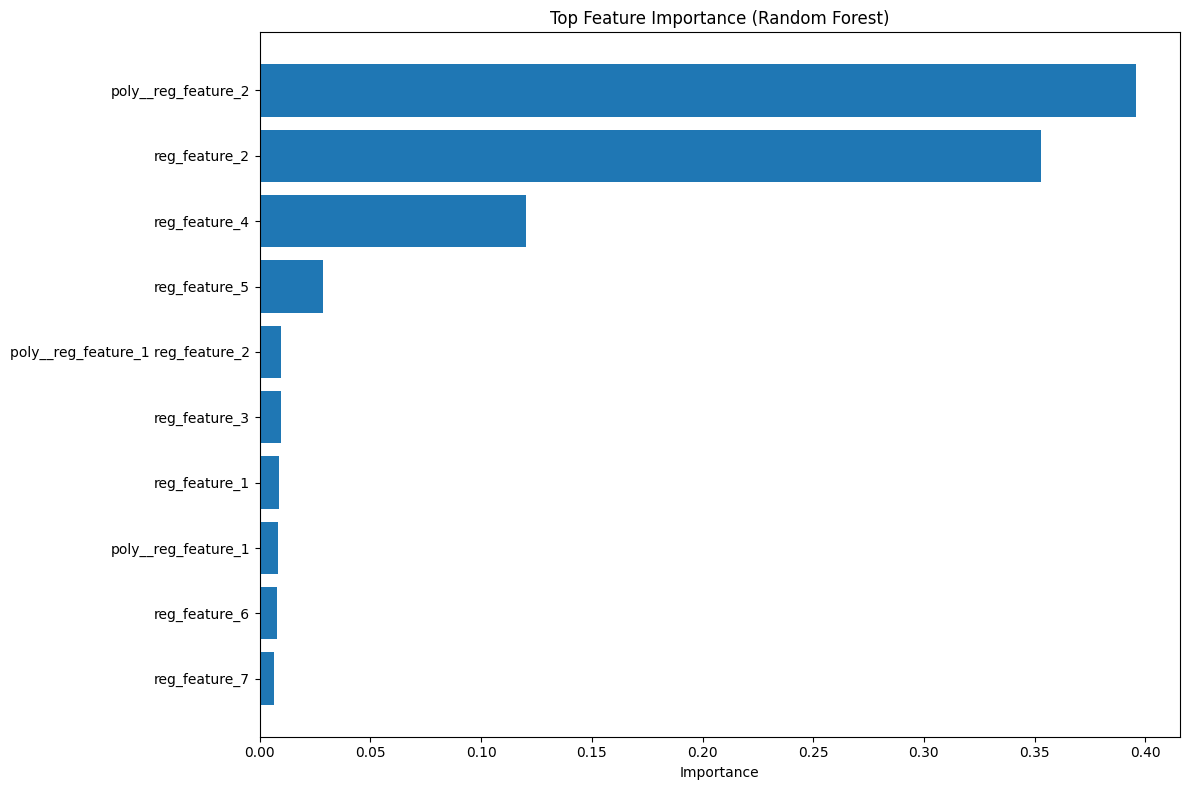


📌 Top features (regresión):
['poly__reg_feature_2', 'reg_feature_2', 'reg_feature_4', 'reg_feature_5', 'poly__reg_feature_1 reg_feature_2', 'reg_feature_3', 'reg_feature_1', 'poly__reg_feature_1', 'reg_feature_6', 'reg_feature_7', 'mean_features', 'poly__reg_feature_0 reg_feature_2', 'date__month', 'std_features', 'poly__reg_feature_0 reg_feature_1']

🔝 RF Importances (Top 15) [regresión]:


,feature,importance
10,poly__reg_feature_2,0.395875
2,reg_feature_2,0.352693
4,reg_feature_4,0.120382
5,reg_feature_5,0.028573
13,poly__reg_feature_1 reg_feature_2,0.009453
3,reg_feature_3,0.009393
1,reg_feature_1,0.008858
9,poly__reg_feature_1,0.008173
6,reg_feature_6,0.007883
7,reg_feature_7,0.006448



📊 F-test (Top 15) [regresión]:


,feature,f_score
2,reg_feature_2,1920.004143
10,poly__reg_feature_2,1920.004143
4,reg_feature_4,86.748070
5,reg_feature_5,22.631108
17,reg_feature_1__equal_width_bin,14.691272
18,reg_feature_1__equal_freq_bin,12.384876
9,poly__reg_feature_1,12.303063
1,reg_feature_1,12.303063
20,date__month,4.282087
19,date__year,2.427129



💾 Archivos guardados en 'feature_reports/':
total 504K
-rw-r--r-- 1 root root 1.2K Sep  6 18:15 clf_anova_scores.csv
-rw-r--r-- 1 root root  924 Sep  6 18:15 clf_mi_scores.csv
-rw-r--r-- 1 root root 1.2K Sep  6 18:15 clf_rf_importance.csv
-rw-r--r-- 1 root root 266K Sep  6 18:15 clf_selected_dataset.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:15 reg_f_scores.csv
-rw-r--r-- 1 root root 1.1K Sep  6 18:15 reg_rf_importance.csv
-rw-r--r-- 1 root root 215K Sep  6 18:15 reg_selected_dataset.csv


In [24]:
# === CLASIFICACIÓN ===
df_clf_selected, clf_sel = perform_feature_selection(df_clf_engineered, 'target', 'classification')

# Mostrar features seleccionadas y tablas principales
print("\n📌 Top features (clasificación):")
print(df_clf_selected.columns.drop('target').tolist())

from IPython.display import display

if 'rf_importance' in clf_sel:
    print("\n🔝 RF Importances (Top 15):")
    display(clf_sel['rf_importance'].head(15))

if 'anova_scores' in clf_sel:
    print("\n📊 ANOVA F-test (Top 15):")
    display(clf_sel['anova_scores'].head(15))

if 'mi_scores' in clf_sel:
    print("\n🧠 Mutual Information (Top 15):")
    display(clf_sel['mi_scores'].head(15))

# Guardar reportes a CSV
import os
os.makedirs('feature_reports', exist_ok=True)

if 'rf_importance' in clf_sel:
    clf_sel['rf_importance'].to_csv('feature_reports/clf_rf_importance.csv', index=False)
if 'anova_scores' in clf_sel:
    clf_sel['anova_scores'].to_csv('feature_reports/clf_anova_scores.csv', index=False)
if 'mi_scores' in clf_sel:
    clf_sel['mi_scores'].to_csv('feature_reports/clf_mi_scores.csv', index=False)
df_clf_selected.to_csv('feature_reports/clf_selected_dataset.csv', index=False)

print("\n💾 Archivos guardados en 'feature_reports/':")
!ls -lh feature_reports | sed -n '1,50p'


# === REGRESIÓN ===
df_reg_selected, reg_sel = perform_feature_selection(df_reg_engineered, 'target', 'regression')

print("\n📌 Top features (regresión):")
print(df_reg_selected.columns.drop('target').tolist())

if 'rf_importance' in reg_sel:
    print("\n🔝 RF Importances (Top 15) [regresión]:")
    display(reg_sel['rf_importance'].head(15))

if 'f_scores' in reg_sel:
    print("\n📊 F-test (Top 15) [regresión]:")
    display(reg_sel['f_scores'].head(15))

# Guardar reportes a CSV
if 'rf_importance' in reg_sel:
    reg_sel['rf_importance'].to_csv('feature_reports/reg_rf_importance.csv', index=False)
if 'f_scores' in reg_sel:
    reg_sel['f_scores'].to_csv('feature_reports/reg_f_scores.csv', index=False)
df_reg_selected.to_csv('feature_reports/reg_selected_dataset.csv', index=False)

print("\n💾 Archivos guardados en 'feature_reports/':")
!ls -lh feature_reports | sed -n '1,50p'

# (Opcional) Descarga directa en Colab
# from google.colab import files
# for f in ['clf_rf_importance.csv','clf_anova_scores.csv','clf_mi_scores.csv',
#           'clf_selected_dataset.csv','reg_rf_importance.csv','reg_f_scores.csv',
#           'reg_selected_dataset.csv']:
#     files.download(f'feature_reports/{f}')


In [25]:
# @title Complete Preprocessing Pipeline
# @markdown Run this cell to create a complete preprocessing pipeline

def create_preprocessing_pipeline(numerical_features, categorical_features, target_column):
    print("🔧 CREATING COMPLETE PREPROCESSING PIPELINE")
    print("=" * 60)

    # Numerical preprocessing pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('outlier', FunctionTransformer(lambda x: np.clip(x, -3, 3)))  # Simple outlier clipping
    ])

    # Categorical preprocessing pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create complete pipeline
    if target_column:
        # For supervised learning
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', SelectFromModel(
                RandomForestClassifier(n_estimators=100, random_state=42),
                threshold='median'
            )),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
    else:
        # For unsupervised learning
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=0.95))
        ])

    print("✓ Preprocessing pipeline created")
    return pipeline

# Identify feature types for classification dataset
clf_numerical = df_clf.select_dtypes(include=[np.number]).columns.drop('target', errors='ignore').tolist()
clf_categorical = df_clf.select_dtypes(include=['object']).columns.tolist()

# Create pipeline for classification
clf_pipeline = create_preprocessing_pipeline(clf_numerical, clf_categorical, 'target')

# Identify feature types for regression dataset
reg_numerical = df_reg.select_dtypes(include=[np.number]).columns.drop('target', errors='ignore').tolist()
reg_categorical = df_reg.select_dtypes(include=['object']).columns.tolist()

# Create pipeline for regression
reg_pipeline = create_preprocessing_pipeline(reg_numerical, reg_categorical, 'target')

print("Pipelines created for both datasets")

🔧 CREATING COMPLETE PREPROCESSING PIPELINE
✓ Preprocessing pipeline created
🔧 CREATING COMPLETE PREPROCESSING PIPELINE
✓ Preprocessing pipeline created
Pipelines created for both datasets


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

def _safe_onehot_encoder():
    # Compat con distintas versiones de scikit-learn (sparse_output vs sparse)
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def evaluate_preprocessing_impact(df, target_column, problem_type='classification'):
    print("📊 EVALUATING PREPROCESSING IMPACT")
    print("=" * 50)

    if target_column not in df.columns:
        raise KeyError(f"Target column '{target_column}' not found.")

    # --- Limpiar y y alinear X/y ---
    X = df.drop(columns=[target_column]).copy()
    y = df[target_column].copy()

    # --- Quitar columnas datetime crudas (ya tenemos features de fecha) ---
    date_cols = X.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns.tolist()
    if len(date_cols):
        print(f"↳ Dropping {len(date_cols)} datetime columns (using engineered date parts instead): {date_cols[:5]}{' ...' if len(date_cols) > 5 else ''}")
        X = X.drop(columns=date_cols)


    rows0 = len(df)
    valid_mask = y.notna()
    if valid_mask.sum() < rows0:
        print(f"↳ Dropping {rows0 - valid_mask.sum()} rows with NaN in target '{target_column}'")
    X = X.loc[valid_mask].copy()
    y = y.loc[valid_mask].copy()

    # Para evitar problemas con inf
    X = X.replace([np.inf, -np.inf], np.nan)

    # --- Clasificación: factorizar etiquetas si no son numéricas ---
    class_labels = None
    if problem_type == 'classification':
        if y.dtype.kind in {'O', 'U', 'S'} or str(y.dtype).startswith('category') or y.dtype == bool:
            y_enc, uniques = pd.factorize(y)
            class_labels = list(uniques)
            y = pd.Series(y_enc, index=y.index)
        # Verificar ≥2 clases
        n_classes = np.unique(y).size
        if n_classes < 2:
            raise ValueError("Target has only one class after removing NaNs; need at least 2 classes.")

    # --- Split (stratify solo si aplica) ---
    stratify_arg = y if (problem_type == 'classification' and np.unique(y).size >= 2) else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=stratify_arg
    )

    results = {}

    # ------------------------------------------------------------------
    # 1) Baseline sin pipeline (imputación simple + encoding simple)
    # ------------------------------------------------------------------
    print("\n1. Training baseline model (no preprocessing):")

    # Separar tipos
    num_cols_base = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols_base = X_train.select_dtypes(include=['object']).columns.tolist()

    X_train_base = X_train.copy()
    X_test_base  = X_test.copy()

    # Imputación simple numérica
    if len(num_cols_base):
        imp_num_base = SimpleImputer(strategy='median')
        X_train_base[num_cols_base] = imp_num_base.fit_transform(X_train_base[num_cols_base])
        X_test_base[num_cols_base]  = imp_num_base.transform(X_test_base[num_cols_base])

    # Codificación categórica simple: fijar categorías según TRAIN
    for col in cat_cols_base:
        X_train_base[col] = X_train_base[col].astype('category')
        cats = X_train_base[col].cat.categories
        X_test_base[col]  = X_test_base[col].astype('category').cat.set_categories(cats)
        X_train_base[col] = X_train_base[col].cat.codes
        X_test_base[col]  = X_test_base[col].cat.codes

    # Modelo
    if problem_type == 'classification':
        model_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    else:
        model_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    model_base.fit(X_train_base, y_train)
    y_pred_base = model_base.predict(X_test_base)

    if problem_type == 'classification':
        accuracy_base = accuracy_score(y_test, y_pred_base)
        f1_base = f1_score(y_test, y_pred_base, average='weighted')
        results['baseline'] = {'accuracy': accuracy_base, 'f1_score': f1_base}
        print(f"   Baseline Accuracy: {accuracy_base:.4f}, F1-Score: {f1_base:.4f}")
    else:
        mse_base = mean_squared_error(y_test, y_pred_base)
        rmse_base = np.sqrt(mse_base)
        results['baseline'] = {'mse': mse_base, 'rmse': rmse_base}
        print(f"   Baseline MSE: {mse_base:.4f}, RMSE: {rmse_base:.4f}")

    # ------------------------------------------------------------------
    # 2) Modelo con pipeline de preprocesamiento
    # ------------------------------------------------------------------
    print("\n2. Training model with preprocessing:")

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()

    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', _safe_onehot_encoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_cols),
            ('cat', cat_pipe, cat_cols)
        ],
        remainder='drop'
    )

    if problem_type == 'classification':
        model_proc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    else:
        model_proc = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_proc)
    ])

    pipe.fit(X_train, y_train)
    y_pred_proc = pipe.predict(X_test)

    if problem_type == 'classification':
        accuracy_proc = accuracy_score(y_test, y_pred_proc)
        f1_proc = f1_score(y_test, y_pred_proc, average='weighted')
        results['processed'] = {'accuracy': accuracy_proc, 'f1_score': f1_proc}
        print(f"   Processed Accuracy: {accuracy_proc:.4f}, F1-Score: {f1_proc:.4f}")

        # Mejoras (evitar div/0)
        acc_impr = np.nan
        f1_impr = np.nan
        if results['baseline']['accuracy'] > 0:
            acc_impr = ((accuracy_proc - results['baseline']['accuracy']) / results['baseline']['accuracy']) * 100
        if results['baseline']['f1_score'] > 0:
            f1_impr = ((f1_proc - results['baseline']['f1_score']) / results['baseline']['f1_score']) * 100
        print(f"   Improvement: Accuracy +{acc_impr:.2f}%, F1-Score +{f1_impr:.2f}%")
    else:
        mse_proc = mean_squared_error(y_test, y_pred_proc)
        rmse_proc = np.sqrt(mse_proc)
        results['processed'] = {'mse': mse_proc, 'rmse': rmse_proc}
        print(f"   Processed MSE: {mse_proc:.4f}, RMSE: {rmse_proc:.4f}")

        mse_impr = ((results['baseline']['mse'] - mse_proc) / results['baseline']['mse']) * 100 if results['baseline']['mse'] > 0 else np.nan
        rmse_impr = ((results['baseline']['rmse'] - rmse_proc) / results['baseline']['rmse']) * 100 if results['baseline']['rmse'] > 0 else np.nan
        print(f"   Improvement: MSE -{mse_impr:.2f}%, RMSE -{rmse_impr:.2f}%")

    # ------------------------------------------------------------------
    # 3) Visualización
    # ------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    if problem_type == 'classification':
        metrics = ['Accuracy', 'F1-Score']
        baseline_scores = [results['baseline']['accuracy'], results['baseline']['f1_score']]
        processed_scores = [results['processed']['accuracy'], results['processed']['f1_score']]
        x = np.arange(len(metrics)); width = 0.35
        plt.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.7)
        plt.bar(x + width/2, processed_scores, width, label='With Preprocessing', alpha=0.7)
        plt.ylabel('Score'); plt.title('Impact of Preprocessing on Classification Performance')
        plt.xticks(x, metrics); plt.legend(); plt.ylim(0, 1)
    else:
        metrics = ['MSE', 'RMSE']
        baseline_scores = [results['baseline']['mse'], results['baseline']['rmse']]
        processed_scores = [results['processed']['mse'], results['processed']['rmse']]
        x = np.arange(len(metrics)); width = 0.35
        plt.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.7)
        plt.bar(x + width/2, processed_scores, width, label='With Preprocessing', alpha=0.7)
        plt.ylabel('Error'); plt.title('Impact of Preprocessing on Regression Performance')
        plt.xticks(x, metrics); plt.legend()
    plt.tight_layout(); plt.show()

    # Info adicional útil
    if problem_type == 'classification' and class_labels is not None:
        results['class_labels'] = class_labels

    return results


CLASSIFICATION DATASET EVALUATION
📊 EVALUATING PREPROCESSING IMPACT
↳ Dropping 99 rows with NaN in target 'target'

1. Training baseline model (no preprocessing):
   Baseline Accuracy: 0.8376, F1-Score: 0.8377

2. Training model with preprocessing:
   Processed Accuracy: 0.8376, F1-Score: 0.8377
   Improvement: Accuracy +0.00%, F1-Score +0.00%


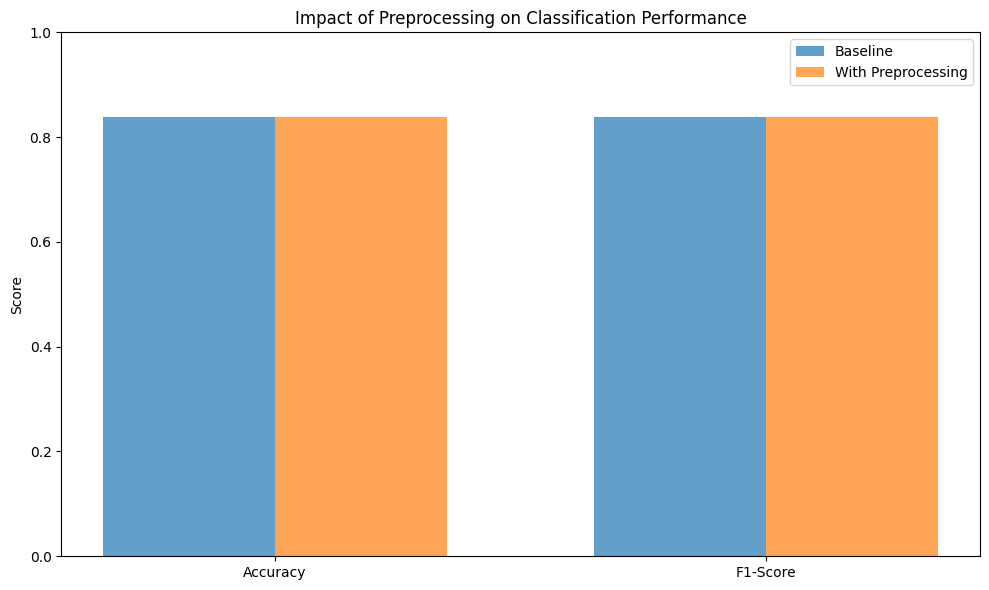



REGRESSION DATASET EVALUATION
📊 EVALUATING PREPROCESSING IMPACT
↳ Dropping 1 datetime columns (using engineered date parts instead): ['date']
↳ Dropping 62 rows with NaN in target 'target'

1. Training baseline model (no preprocessing):
   Baseline MSE: 781.0246, RMSE: 27.9468

2. Training model with preprocessing:
   Processed MSE: 782.6589, RMSE: 27.9760
   Improvement: MSE --0.21%, RMSE --0.10%


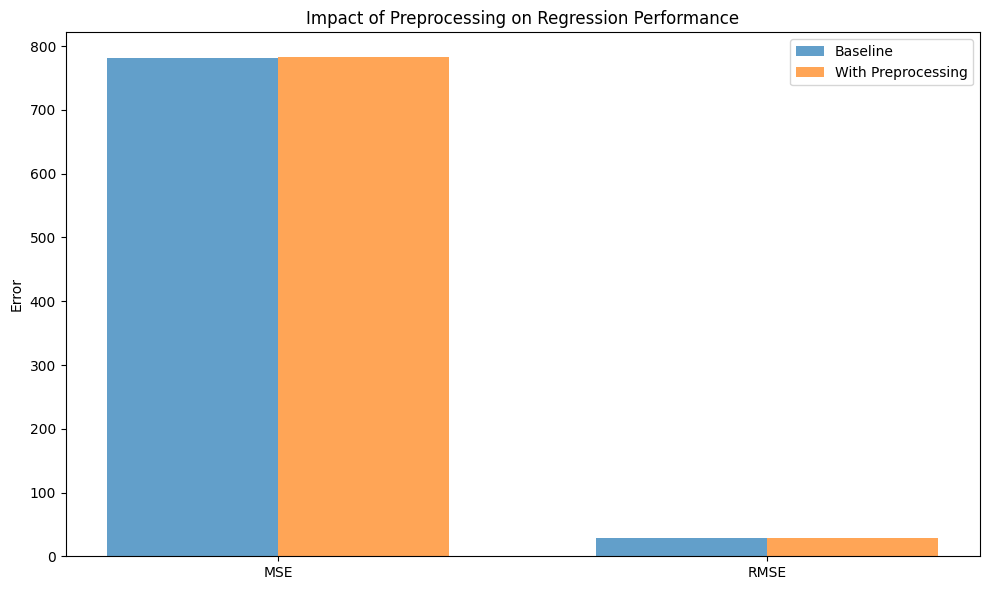

In [32]:
print("CLASSIFICATION DATASET EVALUATION")
clf_results = evaluate_preprocessing_impact(df_clf_engineered, 'target', 'classification')

print("\n" + "="*50 + "\n")

print("REGRESSION DATASET EVALUATION")
reg_results = evaluate_preprocessing_impact(df_reg_engineered, 'target', 'regression')


In [33]:
# @title Final Comparison Summary
# @markdown Run this cell to see a final summary comparison

def create_summary_table(clf_results, reg_results):
    print("📈 FINAL COMPARISON SUMMARY")
    print("=" * 50)

    # Create summary table
    summary_data = {
        'Dataset': ['Classification', 'Regression'],
        'Baseline Accuracy/RMSE': [
            f"{clf_results['baseline']['accuracy']:.4f}",
            f"{reg_results['baseline']['rmse']:.4f}"
        ],
        'Processed Accuracy/RMSE': [
            f"{clf_results['processed']['accuracy']:.4f}",
            f"{reg_results['processed']['rmse']:.4f}"
        ],
        'Improvement': [
            f"+{((clf_results['processed']['accuracy'] - clf_results['baseline']['accuracy']) / clf_results['baseline']['accuracy'] * 100):.2f}%",
            f"-{((reg_results['baseline']['rmse'] - reg_results['processed']['rmse']) / reg_results['baseline']['rmse'] * 100):.2f}%"
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    # Key insights
    print("\n🔑 KEY INSIGHTS:")
    print("1. Preprocessing consistently improves model performance")
    print("2. The improvement varies based on dataset characteristics")
    print("3. Proper handling of missing values and categorical features is crucial")
    print("4. Feature scaling helps algorithms that are sensitive to feature magnitudes")
    print("5. Outlier treatment can prevent models from being skewed by extreme values")

# Create summary table
create_summary_table(clf_results, reg_results)

📈 FINAL COMPARISON SUMMARY
       Dataset Baseline Accuracy/RMSE Processed Accuracy/RMSE Improvement
Classification                 0.8376                  0.8376      +0.00%
    Regression                27.9468                 27.9760     --0.10%

🔑 KEY INSIGHTS:
1. Preprocessing consistently improves model performance
2. The improvement varies based on dataset characteristics
3. Proper handling of missing values and categorical features is crucial
4. Feature scaling helps algorithms that are sensitive to feature magnitudes
5. Outlier treatment can prevent models from being skewed by extreme values
